# IND6212 Project
---

# Preprocessing

In [0]:
# import libraries
import csv
import numpy as np

In [2]:
# if runned on colaboratory
GOOGLE = True
if GOOGLE:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive/')
    path = "/content/drive/My Drive/EPM/PhD/IND6212/Projet/"
else:
    path = ""

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# read intakes
with open('{}data/aac_intakes.csv'.format(path), 'r') as file:
    reader = csv.reader(file)
    header_intake = next(reader)
    intakes = [[value for value in row] for row in reader]

In [0]:
# read outcomes
with open('{}data/aac_outcomes.csv'.format(path), 'r') as file:
    reader = csv.reader(file)
    header_outcome = next(reader)
    outcomes = [[value for value in row] for row in reader]

In [0]:
# convert numpy array
header_intake = np.asarray(header_intake)
header_outcome = np.asarray(header_outcome)

intakes = np.asarray(intakes)
outcomes = np.asarray(outcomes)

In [6]:
print("Intakes")
for i, c in enumerate(header_intake):
    print("{} : {}".format(i, c))

Intakes
0 : age_upon_intake
1 : animal_id
2 : animal_type
3 : breed
4 : color
5 : datetime
6 : datetime2
7 : found_location
8 : intake_condition
9 : intake_type
10 : name
11 : sex_upon_intake


In [7]:
print("Outcomes")
for i, c in enumerate(header_outcome):
    print("{} : {}".format(i, c))

Outcomes
0 : age_upon_outcome
1 : animal_id
2 : animal_type
3 : breed
4 : color
5 : date_of_birth
6 : datetime
7 : monthyear
8 : name
9 : outcome_subtype
10 : outcome_type
11 : sex_upon_outcome


In [8]:
# get the last outcome (it can be transfered multiple times, we want the last update)
# if no outcome, then we remove the example (line)
counter = 0
data = []
for i, x in enumerate(intakes, 1):
    index = np.where(outcomes[:, 1] == x[1])
    if len(index[0]) > 0 and outcomes[index[0][-1], 10]:
        data.append(np.concatenate((x, [outcomes[index[0][-1], 10]])))
    else:
        counter += 1
    print("\r{} | {}".format(i - counter, counter), end=" ")

79776 | 411 

In [0]:
# add the outcome to data
data = np.asarray(data)
header = np.concatenate((header_intake, ["outcome"]))

The author of the dataset explained that Rto-Adopt = Return to Owner and Disposal = Died (see [link](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/discussion/56707#latest-329163))

In [0]:
for row in data:
    if row[-1] == "Rto-Adopt":
        row[-1]="Return to Owner"
    if row[-1] == "Disposal":
        row[-1]="Died"

In [0]:
# remove the animal id
data = np.delete(data, 1, axis=1)
header = np.delete(header, 1, axis=0)

In [0]:
# convert intake date into a real value (year)
for x in data:
    s = x[0].split()
    if "year" in s[1]:
        x[0] = float(s[0])
    if "month" in s[1]:
        x[0] = float(s[0]) / 12.
    if "week" in s[1]:
        x[0] = float(s[0]) / 52.
    if "day" in s[1]:
        x[0] = float(s[0]) / 365.

In [0]:
# convertir animal breed to integer
mapping_breed, breed_int = np.unique(data[:, 2], return_inverse=True)
data = np.delete(data, [1, 2], axis=1)
header = np.delete(header, [1, 2], axis=0)
data = np.concatenate((data, breed_int.reshape(-1, 1)), axis=1)
header = np.concatenate((header, ["animal_breed"]))

In [0]:
# convert color to integer
mapping_color, color_int = np.unique(data[:, 1], return_inverse=True)
data = np.delete(data, 1, axis=1)
header = np.delete(header, 1, axis=0)
data = np.concatenate((data, color_int.reshape(-1, 1)), axis=1)
header = np.concatenate((header, ["color"]))

In [0]:
# remove location
data = np.delete(data, 3, axis=1)
header = np.delete(header, 3, axis=0)

In [16]:
# check if datetime and datetime2 are identical
if np.array_equal(data[:, 1], data[:, 2]):
    print("Datetime duplicated")
else:
    print("Datetime not duplicated")

Datetime duplicated


In [0]:
# remove datetime2
data = np.delete(data, 2, axis=1)
header = np.delete(header, 2, axis=0)

In [0]:
# convert condition to integer
mapping_condition, condition_int = np.unique(data[:, 2], return_inverse=True)
data = np.delete(data, 2, axis=1)
header = np.delete(header, 2, axis=0)
data = np.concatenate((data, condition_int.reshape(-1,1)), axis=1)
header = np.concatenate((header, ["condition"]))

In [0]:
# convert type to integer
mapping_type, type_int = np.unique(data[:, 2], return_inverse=True)
data = np.delete(data, 2, axis=1)
header = np.delete(header, 2, axis=0)
data = np.concatenate((data, type_int.reshape(-1,1)), axis=1)
header = np.concatenate((header, ["type"]))

In [20]:
# check if name as any impact
out = list(set(data[:,4]))
out_name = [0 for _ in out]
out_noname = [0 for _ in out]
name, noname = 0, 0

for d in data:
    if d[2]:
        name += 1
        out_name[out.index(d[4])] += 1
    else:
        noname += 1
        out_noname[out.index(d[4])] += 1
out_noname = [o/noname for o in out_noname]
out_name = [o/name for o in out_name]

print("{:20s} | {:^15s} | {:^15s}".format("Outcome", "with name", "without name"))
print("-"*56)
for a, b, c in zip(out, out_name, out_noname):
    print("{:20s} | {:^15.2%} | {:^15.2%}".format(a, b, c))

Outcome              |    with name    |  without name  
--------------------------------------------------------
Died                 |      0.45%      |      3.05%     
Transfer             |     20.55%      |     51.64%     
Relocate             |      0.00%      |      0.06%     
Return to Owner      |     25.85%      |      1.91%     
Adoption             |     50.43%      |     23.37%     
Euthanasia           |      2.66%      |     19.92%     
Missing              |      0.06%      |      0.04%     


In [0]:
# the presence of a name seems to have an impact on the outcome
# its value should not have any effect (difficult to evaluate)
# replace absence of a name by 0 and presence of a name by 1
for row in data:
    row[2] = 1 if row[2] else 0

In [22]:
# sex analysis
sex, count = np.unique(data[:, 3], return_counts=True)
for s, c in zip(sex, count):
    print("{:20s} : {:6d} ({:6.1%})".format(s, c, c / data.shape[0]))

Intact Female        :  23739 ( 29.8%)
Intact Male          :  25355 ( 31.8%)
NULL                 :      1 (  0.0%)
Neutered Male        :  12728 ( 16.0%)
Spayed Female        :  11168 ( 14.0%)
Unknown              :   6785 (  8.5%)


In [23]:
# check if name as any impact
out = list(set(data[:, 4]))
sex = list(set(data[:, 3]))
table = [[0 for _ in out] for _ in sex]
for d in data:
    table[sex.index(d[3])][out.index(d[4])] += 1

print(" " * 14, end="")
for o in out:
    print("{:^14s}".format(o), end="")
print("")
for i, s in zip(table, sex):
    print("{:^14s}".format(s), end="")
    for j in i:
        print("{:^14d}".format(j), end="")
    print("")

                   Died        Transfer      Relocate   Return to Owner   Adoption     Euthanasia     Missing    
   Unknown         476           2747           14            84            70           3392           2       
     NULL           0             0             0             1             0             0             0       
 Intact Male       255           8282           0            3523         12178          1099           18      
Intact Female      172           8447           1            2246         11972          882            19      
Neutered Male       42           2429           0            4958          4699          597            3       
Spayed Female       48           2099           0            3950          4690          377            4       


In [0]:
# we cannot remove unknown because it seems to have an impact on the outcome (extremly low adoption rate)
# there is only one NULL, which is suspect, we'll remove this
id = np.where(data[:,3] == "NULL")[0][0]
data = np.delete(data, id, axis=0)

In [0]:
# convert sex to integer
mapping_sex, sex_int = np.unique(data[:, 3], return_inverse=True)
data = np.delete(data, 3, axis=1)
header = np.delete(header, 3, axis=0)
data = np.concatenate((data, sex_int.reshape(-1,1)), axis=1)
header = np.concatenate((header, ["sex"]))

In [0]:
# keep only month for datetime
mapping_sex, sex_int = np.unique(data[:, 3], return_inverse=True)
for d in data:
    d[1] = int(d[1].split("-")[1])

In [0]:
# put labels (outcomes) in separate matrix
mapping_outcome, labels = np.unique(data[:, 3], return_inverse=True)
x = np.delete(data, 3, axis=1)
header = np.delete(header, 3, axis=0)

In [28]:
print(mapping_outcome)

['Adoption' 'Died' 'Euthanasia' 'Missing' 'Relocate' 'Return to Owner'
 'Transfer']


In [0]:
x = x.astype("float32")
labels = labels.astype("int")

In [30]:
for i, (row, label) in enumerate(zip(x, labels)):
    for h, value in zip(header, row):
        print("{:20s} : {}".format(h, value))
    print("\tOutcome: {}".format(label))
    print("-----------------------")
    if i > 2:
        break

age_upon_intake      : 8.0
datetime             : 7.0
name                 : 1.0
animal_breed         : 1007.0
color                : 498.0
condition            : 3.0
type                 : 3.0
sex                  : 3.0
	Outcome: 5
-----------------------
age_upon_intake      : 0.9166666865348816
datetime             : 4.0
name                 : 1.0
animal_breed         : 231.0
color                : 382.0
condition            : 3.0
type                 : 3.0
sex                  : 1.0
	Outcome: 5
-----------------------
age_upon_intake      : 0.07692307978868484
datetime             : 10.0
name                 : 0.0
animal_breed         : 952.0
color                : 194.0
condition            : 7.0
type                 : 3.0
sex                  : 0.0
	Outcome: 6
-----------------------
age_upon_intake      : 4.0
datetime             : 6.0
name                 : 1.0
animal_breed         : 924.0
color                : 415.0
condition            : 3.0
type                 : 3.0
sex   

In [0]:
# convert outcomes (y) to one_hot
y = np.eye(len(set(labels)))[labels]

In [32]:
print("Nb attributes: {}".format(x.shape[1]))
print("Nb different outcomes: {}".format(len(set(labels))))

Nb attributes: 8
Nb different outcomes: 7


# Model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [0]:
# function to plot the learning graphs
def plot_history(history):
  fig, axes = plt.subplots(1, 2, figsize=(8, 4),)
  
  # summarize history for accuracy
  axes[0].plot(history.history['acc'])
  axes[0].plot(history.history['val_acc'])
  axes[0].set_title('Model accuracy')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_xlabel('Epoch')
  
  axes[0].legend(['Train', 'Validation'], title="Dataset")
  # summarize history for loss
  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].set_title('Model loss')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(['Train', 'Validation'], title="Dataset")
 
  plt.show()

In [0]:
#normalize x
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [0]:
# split dataset into a training, validation and test set
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, stratify=y)
# we split first (train/test) then (train/valid) 12.5% of 80% is the same as 10% of 100%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, stratify=y_train)

In [37]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(55842, 8)
(7978, 8)
(15955, 8)


In [38]:
from keras import metrics
from keras import callbacks
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model

Using TensorFlow backend.


In [39]:
input = Input(shape=(8, ))
dense = BatchNormalization()(input)
dense = Dense(32)(dense)
dense = BatchNormalization()(dense)
dense = Activation('relu')(dense)
dense = Dense(16)(dense)
dense = BatchNormalization()(dense)
dense = Activation('relu')(dense)
dense = Dense(7)(dense)
output = Activation('softmax')(dense)

model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=9999,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks.EarlyStopping(
                    monitor='val_acc',
                    min_delta=0.001,
                    patience=10,
                    restore_best_weights=True)])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 55842 samples, validate on 7978 samples
Epoch 1/9999
55842/55842 [==============================] - 5s 98us/step - loss: 1.4270 - acc: 0.4944 - val_loss: 1.1100 - val_acc: 0.5851
Epoch 2/9999
55842/55842 [==============================] - 2s 40us/step - loss: 1.0349 - acc: 0.5913 - val_loss: 0.9894 - val_acc: 0.6033
Epoch 3/9999
55842/55842 [==============================] - 2s 38us/step - loss: 0.9713 - acc: 0.6095 - val_loss: 0.9527 - val_acc: 0.6164
Epoch 4/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9462 - acc: 0.6166 - val_loss: 0.9361 - val_acc: 0.6215
Epoch 5/9999
55842/55842 [==============================] - 2s 41us/step - loss: 0.9357 - acc: 0.6199 - val_loss: 0.9249 - val_acc: 0.6267
Epoch 6/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9279 - acc: 0.6221 - val_loss: 0.9189 - val_acc: 0.62

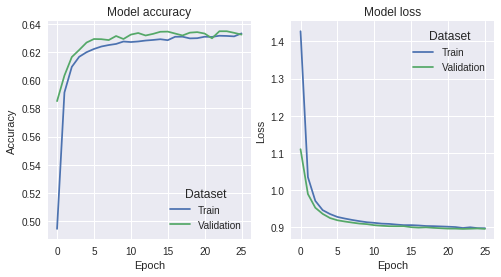

In [40]:
plot_history(history)

In [0]:
# not accurate enough, let's only check if the animal is adopted
binary_y = [int(label[0] == 1) for label in y]
# split dataset into a training, validation and test set
x_train, x_test, y_train, y_test = train_test_split(x_scaled, binary_y, test_size=0.2, stratify=binary_y)
# we split first (train/test) then (train/valid) 12.5% of 80% is the same as 10% of 100%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, stratify=y_train)

In [42]:
input = Input(shape=(8, ))
dense = BatchNormalization()(input)
dense = Dense(32)(dense)
dense = BatchNormalization()(dense)
dense = Activation('relu')(dense)
dense = Dense(16)(dense)
dense = BatchNormalization()(dense)
dense = Activation('relu')(dense)
dense = Dense(1)(dense)
output = Activation('sigmoid')(dense)

model = Model(inputs=input, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=9999,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks.EarlyStopping(
                    monitor='val_acc',
                    min_delta=0.001,
                    patience=10,
                    restore_best_weights=True)])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 55842 samples, validate on 7978 samples
Epoch 1/9999
55842/55842 [==============================] - 3s 58us/step - loss: 0.5978 - acc: 0.6705 - val_loss: 0.5816 - val_acc: 0.6839
Epoch 2/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.5729 - acc: 0.6936 - val_loss: 0.5708 - val_acc: 0.6906
Epoch 3/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.5648 - acc: 0.6976 - val_loss: 0.5635 - val_acc: 0.6958
Epoch 4/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.5601 - acc: 0.6988 - val_loss: 0.5614 - val_acc: 0.6975
Epoch 5/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.5571 - acc: 0.7001 - val_loss: 0.5572 - val_acc: 0.6967
Epoch 6/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.5542 - acc: 0.7016 - val_loss: 0.5559 - val_acc: 0.6987
Epoch 7/9999
55842/55842 [==============================] - 2s 41us/step - loss: 0.5529 - acc: 0.7014 - val_loss: 0.5

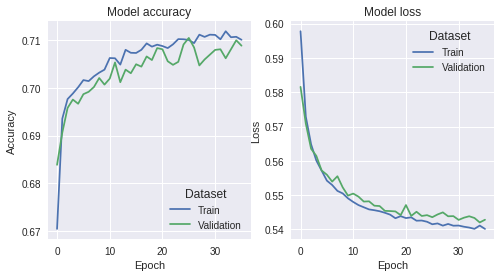

In [43]:
plot_history(history)

In [0]:
# Let's try with one hot vector
one_hot_animal_breed = np.eye(len(set(x[:,3])))[x[:,3].astype("int")]
one_hot_color = np.eye(len(set(x[:,4])))[x[:,4].astype("int")]
one_hot_condition = np.eye(len(set(x[:,5])))[x[:,5].astype("int")]
one_hot_type = np.eye(len(set(x[:,6])))[x[:,6].astype("int")]
one_hot_sex = np.eye(len(set(x[:,7])))[x[:,7].astype("int")]

x_one_hot = np.concatenate((x[:,:3], one_hot_animal_breed, one_hot_color, one_hot_condition, one_hot_type, one_hot_sex), axis=1)

In [0]:
# split dataset into a training, validation and test set
x_train, x_test, y_train, y_test = train_test_split(x_one_hot, binary_y, test_size=0.2, stratify=y)
# we split first (train/test) then (train/valid) 12.5% of 80% is the same as 10% of 100%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, stratify=y_train)

In [50]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(55842, 2709)
(7978, 2709)
(15955, 2709)


In [51]:
input = Input(shape=(2709, ))
dense = BatchNormalization()(input)
dense = Dense(32)(dense)
dense = BatchNormalization()(dense)
dense = Activation('relu')(dense)
dense = Dense(16)(dense)
dense = BatchNormalization()(dense)
dense = Activation('relu')(dense)
dense = Dense(1)(dense)
output = Activation('sigmoid')(dense)

model = Model(inputs=input, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=9999,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks.EarlyStopping(
                    monitor='val_acc',
                    min_delta=0.001,
                    patience=10,
                    restore_best_weights=True)])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 55842 samples, validate on 7978 samples
Epoch 1/9999
55842/55842 [==============================] - 5s 87us/step - loss: 0.5861 - acc: 0.6729 - val_loss: 0.5662 - val_acc: 0.7033
Epoch 2/9999
55842/55842 [==============================] - 3s 60us/step - loss: 0.5258 - acc: 0.7255 - val_loss: 0.5711 - val_acc: 0.7111
Epoch 3/9999
55842/55842 [==============================] - 3s 62us/step - loss: 0.5067 - acc: 0.7398 - val_loss: 0.5755 - val_acc: 0.7097
Epoch 4/9999
55842/55842 [==============================] - 4s 63us/step - loss: 0.4938 - acc: 0.7462 - val_loss: 0.5850 - val_acc: 0.7110
Epoch 5/9999
55842/55842 [==============================] - 4s 63us/step - loss: 0.4840 - acc: 0.7537 - val_loss: 0.5932 - val_acc: 0.7115
Epoch 6/9999
55842/55842 [==============================] - 4s 64us/step - loss: 0.4760 - acc: 0.7580 - val_loss: 0.6070 - val_acc: 0.7122
Epoch 7/9999
55842/55842 [==============================] - 4s 64us/step - loss: 0.4694 - acc: 0.7620 - val_loss: 0.6

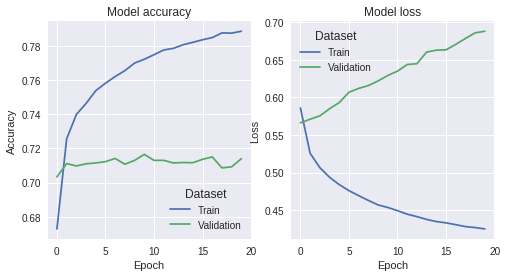

In [52]:
plot_history(history)